## Spice 

Here we consider the spice variable. 

In [1]:
import numpy as np
import xarray as xr

import glidertools as gt
from cmocean import cm as cmo

import gsw

import matplotlib.pyplot as plt

In [2]:
plt.style.use('seaborn-colorblind')
plt.rcParams['font.size'] = 12

In [3]:
ds_660_rho = xr.open_dataset('data/ctd_660_isopycnal_grid_14_july_2021.nc')

In [4]:
ds_660_rho

<xarray.Dataset>
Dimensions:       (dives: 1007, rho_grid: 901)
Coordinates:
  * rho_grid      (rho_grid) float64 27.0 27.0 27.0 27.0 ... 27.9 27.9 27.9 27.9
  * dives         (dives) float64 1.0 1.5 2.0 2.5 ... 508.0 508.5 509.0 509.5
Data variables:
    ctd_pressure  (rho_grid, dives) float64 ...
    CT            (rho_grid, dives) float64 ...
    SA            (rho_grid, dives) float64 ...
    latitude      (rho_grid, dives) float64 ...
    longitude     (rho_grid, dives) float64 ...
    days          (rho_grid, dives) float64 ...

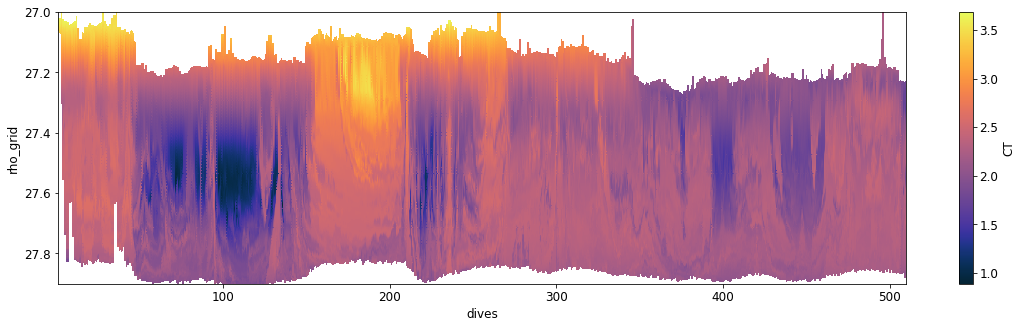

In [13]:
plt.figure(figsize=(19,5))
ds_660_rho.CT.plot(cmap=cmo.thermal)
plt.gca().invert_yaxis()

In [14]:
SA_lin = np.linspace(34.0, 35.1, 51)
CT_lin = np.linspace(0.5, 4, 51)

[SA_grid, CT_grid] = np.meshgrid(SA_lin, CT_lin)

rho_grid = gsw.sigma0(SA_grid, CT_grid)

Text(0, 0.5, 'CT')

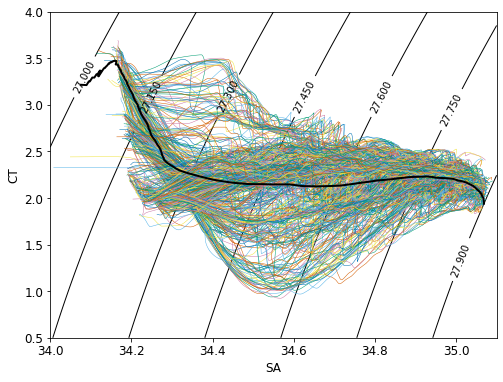

In [19]:
plt.figure(figsize=(8,6))
for i in range(0,1007,2):
    plt.plot(ds_660_rho.SA[:,i], ds_660_rho.CT[:,i], linewidth=0.5)
plt.plot(ds_660_rho.SA.mean('dives'),
         ds_660_rho.CT.mean('dives'), linewidth=2., color='k')

CS=plt.contour(SA_lin, CT_lin, rho_grid, linewidths=1, colors='k')
plt.clabel(CS, inline=1, fontsize=10)
plt.xlabel('SA')
plt.ylabel('CT')

In [22]:
rho0=1000
alpha_grid = gsw.alpha(SA_grid, CT_grid,50)*1e5
beta_grid  = gsw.beta(SA_grid, CT_grid,50)*1e5

<a list of 7 text.Text objects>

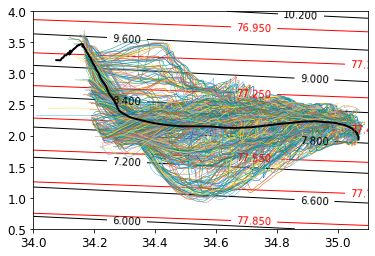

In [24]:
for i in range(0,1007,2):
    plt.plot(ds_660_rho.SA[:,i], ds_660_rho.CT[:,i], linewidth=0.5)
plt.plot(ds_660_rho.SA.mean('dives'),
         ds_660_rho.CT.mean('dives'), linewidth=2., color='k')

CS = plt.contour(SA_lin, CT_lin, alpha_grid, linewidths=1, colors='k')
plt.clabel(CS, inline=1, fontsize=10)

CS = plt.contour(SA_lin, CT_lin, beta_grid, linewidths=1, colors='r')
plt.clabel(CS, inline=1, fontsize=10)



In [25]:
# Pick constant alpha and beta for convenience (can always update later)
alpha = 8e-5
beta  = 77.4e-5

In [26]:
# remove a mean per isopycnal
dCT = ds_660_rho.CT  - ds_660_rho.CT.mean('dives')
dSA = ds_660_rho.SA - ds_660_rho.SA.mean('dives')

In [40]:
spice1 = (2*alpha*dCT).rename('Spice')
spice2 = (2*beta*dSA).rename('Spice')

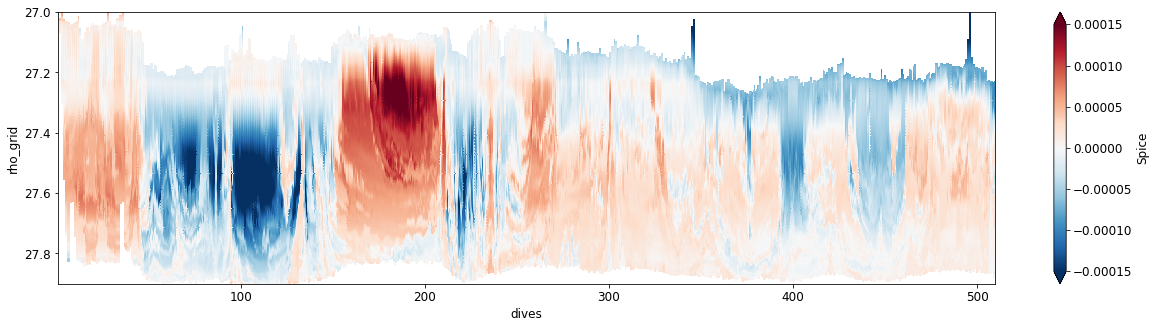

In [49]:
plt.figure(figsize=(21,5))
spice1.plot(vmin=-1.5e-4)
#plt.xlim([100,200])
plt.gca().invert_yaxis()

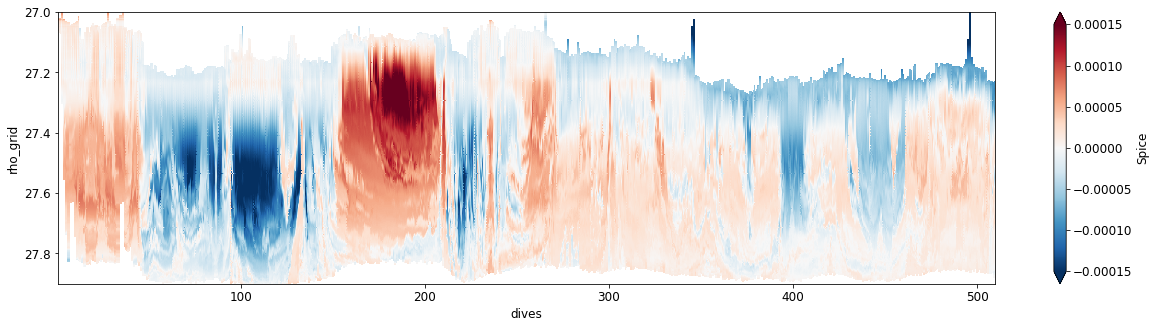

In [50]:
plt.figure(figsize=(21,5))
spice2.plot(vmin=-1.5e-4)
#plt.xlim([100,200])
plt.gca().invert_yaxis()

Text(0.5, 1.0, 'The effect of choosing constant alpha and beta')

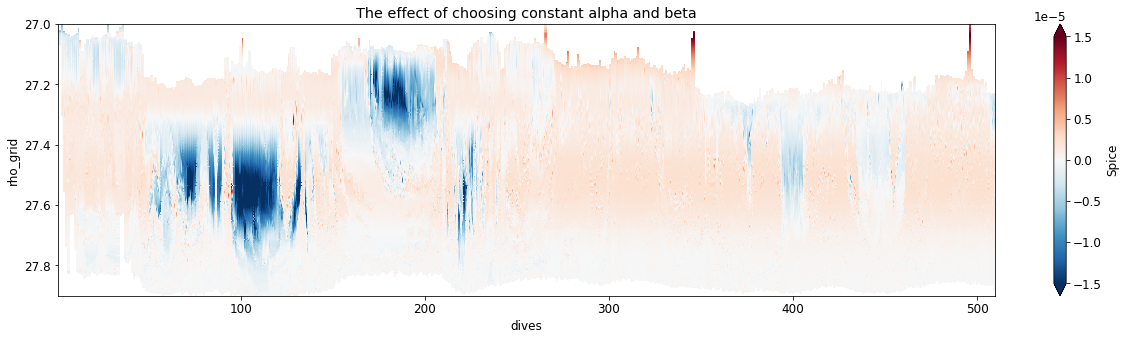

In [54]:
plt.figure(figsize=(21,5))
(spice1- spice2).plot(vmin=-1.5e-5)
#plt.xlim([100,200])
plt.gca().invert_yaxis()
plt.title('The effect of choosing constant alpha and beta')
# An order of magnitude smaller but might be important when looking at spectra

In [44]:
spice1.std().values, (spice1-spice2).std().values

(array(4.91165043e-05), array(2.81974092e-06))

In [ ]:
# Interpolate from the density only mean isopycnal depth for 

In [109]:
Pmean = ds_660_rho.ctd_pressure.mean('dives')
Pmean_smooth = ds_660_rho.ctd_pressure.mean('dives').rolling(rho_grid= 30, center=True).mean()
# do a little bit of smoothing. This is not a problem since all this is just for visualization. 

Text(0, 0.5, 'dPressure')

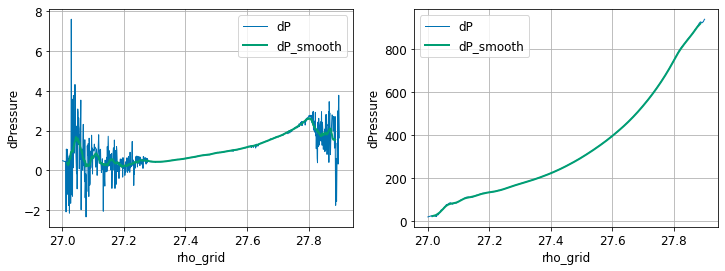

In [110]:
plt.figure(figsize=(12,4))
plt.subplot(121)
Pmean.diff('rho_grid').plot(linewidth=1, label='dP')
Pmean_smooth.diff('rho_grid').plot(linewidth=2, label='dP_smooth')

plt.grid()
plt.legend()
plt.ylabel('dPressure')

plt.subplot(122)
Pmean.plot(linewidth=1, label='dP')
Pmean_smooth.plot(linewidth=2, label='dP_smooth')

plt.grid()
plt.legend()
plt.ylabel('dPressure')

In [ ]:
from scipy import interpolate

In [126]:
def func_var_int_pmean(ds): 
    Pmean_grid = np.linspace(0,1000,501)
    
    #ds = ds[var]
    
    ds_nonan = ds.where(~np.isnan(ds) & ~np.isnan(Pmean_smooth), drop=True)
    Pmean_nonan = Pmean_smooth.where(~np.isnan(ds) & ~np.isnan(Pmean_smooth), drop=True)
    
    if len(ds_nonan) > 2:
        f = interpolate.PchipInterpolator(Pmean_nonan.values, ds_nonan.values , extrapolate=False)
        ds_on_Pmean = f(Pmean_grid)
    else:
        ds_on_Pmean = np.nan*Pmean_grid
    
    return xr.DataArray(ds_on_Pmean.reshape((-1,1)),
                        dims = ['Pmean', 'dives'],
                        coords = {'Pmean': Pmean_grid, 'dives': [ds.dives.values]})
    

In [128]:
# Interpolate to iso
dive_ind=0
spice_on_Pmean = func_var_int_pmean(spice1.isel(dives=dive_ind))

for dive_ind in range(1, len(spice1.dives)):
    if np.mod(dive_ind, 100)==0:
        print(dive_ind)
    spice_on_Pmean = xr.concat([spice_on_Pmean, func_var_int_pmean(spice1.isel(dives=dive_ind))]
                              , dim='dives')
    

100
200
300
400
500
600
700
800
900
1000


In [136]:
spice_on_Pmean=spice_on_Pmean.rename('Spice')

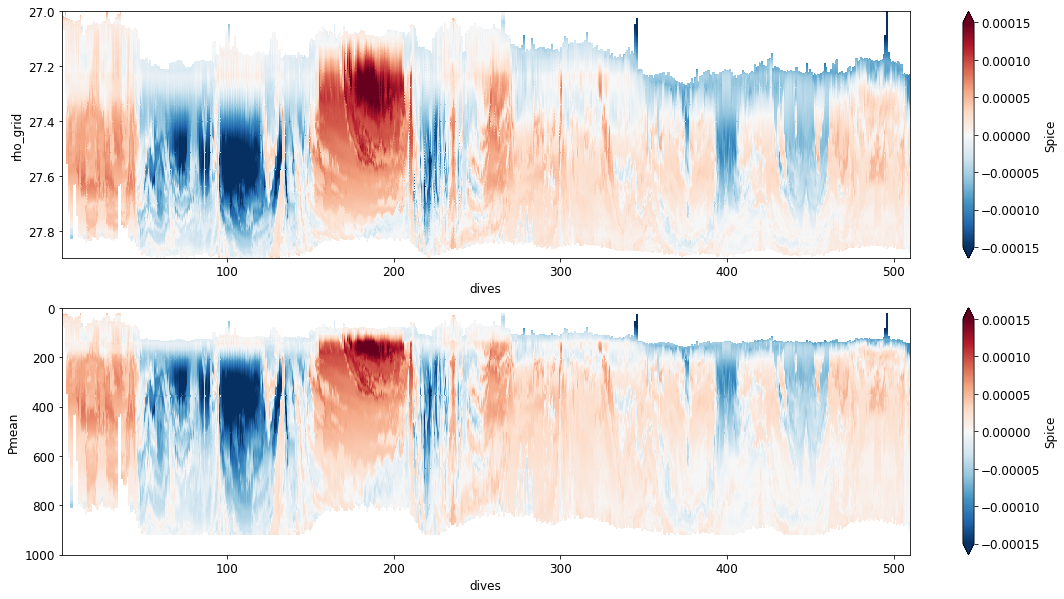

In [137]:
plt.figure(figsize=(19,10))

plt.subplot(211)
spice1.plot(vmin=-1.5e-4)
plt.gca().invert_yaxis()

plt.subplot(212)
spice_on_Pmean.plot(vmin=-1.5e-4)
plt.gca().invert_yaxis()

One of the amazing things here (in contrast to Jaeger et al or Klymak et al) is that there there is a lot of spice variance even at the deeper levels.

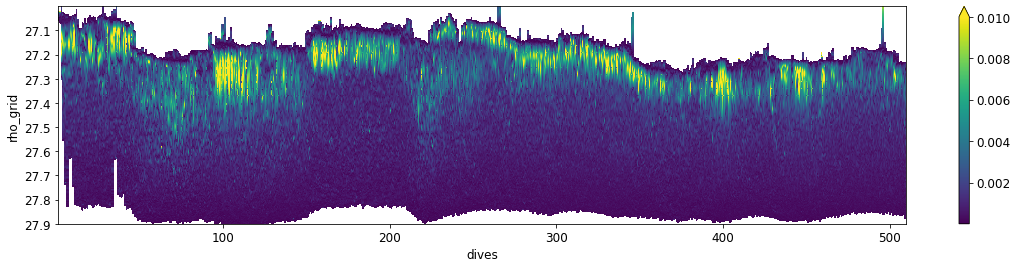

In [149]:
plt.figure(figsize=(19,4))
( ds_660_rho.rho_grid.diff('rho_grid')/ds_660_rho.ctd_pressure.diff('rho_grid') ).plot(vmax=1e-2)

plt.gca().invert_yaxis()